In [39]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import gurobipy as gp
from gurobipy import GRB
import datetime as dt
import matplotlib.pyplot as plt
import csv

In [49]:
# STEP 0, DATA PREPROCESSING: 

# Convert the raw data into a format of rows as groups and columns as classes
# The values in the table are the probability that a student in this group would join the waitlist for this particular class
def process_raw_data(): 	
	wl=pd.read_csv("onlywaitlists.csv")

	wl_data=wl.groupby(['Class']).sum().reset_index()
	wl_data=wl_data.drop(43)

	wl_tr=wl_data.drop(['Class'], axis=1).transpose()
	wl_tr=wl_tr.drop(["OTHER", "Total", "Cap"], axis=0)
	
	wl_tr["total waitlists"]=wl_tr.sum(axis=1)
	wl_tr["total students"]=wl.iloc[0]

	# compute the ratio betweem waitlists and total students
	# this ratio can be interpeted as the average number of waitlists joined by students in this group
	wl_tr["ratio"]=wl_tr["total waitlists"]/wl_tr["total students"]

	# divide the number of waitlists per each course by the total number of waitlists
	# this can be interpreted as the probability that a student in this group would join the waitlist for this particular class
	wl_final=wl_tr[range(0,43)].div(wl_tr["total waitlists"], axis=0)

	# bring back the previous columns, fill in naN values with 0
	wl_final['waitlist']=wl_tr["total waitlists"]
	wl_final['students']=wl_tr["total students"]
	wl_final['ratio']=wl_tr["ratio"]
	wl_final=wl_final.fillna(0)

	# get rid of rows with no students
	wl_final = wl_final[wl_final["students"] > 2]
	return wl_final

# Get course capacities from the raw data
def capacities_from_raw_data(): 
	wl_totcap=wl.groupby(['Class']).sum()[["Total", "Cap"]]
	wl_totcap['Ratio']=wl_totcap["Total"]/wl_totcap["Cap"]
	wl_totcap=wl_totcap.reset_index().drop(43)
	wl_totcap=wl_totcap.sort_values(by="Ratio")
	return wl_totcap

	


In [50]:
cap = wl_totcap[32:]["Cap"].tolist()
# Fraction of waitlists of just the top 11 classes
frac=wl_totcap[32:]["Total"].sum()/wl_totcap["Total"].sum()
#Average number of waitlists/enrollments across all students
mu=wl_totcap["Total"].sum()/wl_final["students"].sum()
# Probability that a student ranks 0 classes
prob = sp.poisson.cdf(0, mu)

# Probability that they would rnak each of these classes
wl_total=wl_totcap[32:]["Total"].sum()
class_prob=wl_totcap[32:]["Total"]/wl_total

# Probability that a student that ranks > 0 classes * an approximate probability that they would rank one of the top 11 classes
# An approximate number of students that were ranking these top 11 classes
wl_final["students"].sum()*(1-prob)*frac

890.4874636380856

[280.0, 100.0, 398.0, 30.0, 360.0, 60.0, 300.0, 40.0, 75.0, 30.0, 100.0]

In [45]:

class_prob

37    0.115252
38    0.046869
22    0.189013
5     0.014599
15    0.198233
12    0.033807
16    0.175567
27    0.025355
1     0.066462
3     0.027276
31    0.107568
Name: Total, dtype: float64

In [46]:
def sample_class_num(mean, N):
    sample=np.round(np.random.poisson(mean, N))
    sample[sample<0]=0
    return sample

# randomly chooses courses according to the distribution
def course_ranking(class_num, course_prob):
    if(np.all(course_prob == 0)):
        print("all 0")
        return np.zeros(class_num)
    return np.random.choice(11,min(class_num, np.count_nonzero(course_prob)),p=course_prob, replace=False)

# for a certain group compute a sample of course rankings
def sample_course_ranking(size):
    class_num=np.repeat(3,size)
    rank=[course_ranking(x, class_prob) for x in class_num]
    return rank

def generate_demand_set(arr, max_bundle_size):
    print(arr)
    possible_bundles = []
    for i in range(len(arr)):
        for j in range(i + 1, len(arr) + 1):
            print(i,j)
            bundle = arr[i:j]
            possible_bundles.append((sum(range(i,j)), bundle))
    print(possible_bundles)
    possible_bundles.append((sum(0,2), [arr[0], arr[2]]))
    print("bundles")
    #put in order of utility
    possible_bundles.sort(key=lambda x: (x[0], len(x[1])), reverse=True)
    print("POSSIBLE BUNDLES", possible_bundles)
    #get rid of bundles that are too large
    final_possible_bundles = [x[1] for x in possible_bundles if len(x) <= max_bundle_size]
    return final_possible_bundles

def one_hot_encode(input_list):
    encoded_vector = np.zeros(11)
    encoded_vector[input_list] = 1
    return encoded_vector.tolist()

def demand_set_to_one_hot(all_demand_set):
	one_hot_demand_sets = []
	for student_ds in all_demand_set:
		student_one_hot_ds = []
		for bundle in student_ds:
			one_hot = one_hot_encode(bundle)
			student_one_hot_ds.append(one_hot)
		one_hot_demand_sets.append(student_one_hot_ds)
	return one_hot_demand_sets

def get_all_demand_set(rank,max_bundle_size=3):
    all_demand_sets = []
    for student in rank:
        demand_set = generate_demand_set(student, max_bundle_size)
        all_demand_sets.append(demand_set)

    return all_demand_sets

def pad_arrays(allocations):
	max_len = len(max(allocations, key=len))
	for allocation in allocations:
		while len(allocation) < max_len:
			allocation.append(allocation[-1])
	return allocations

In [47]:
def generate_full_student_dataset(size):
	complete_demand_set = []

	rank=sample_course_ranking(size)
	all_demand_set=get_all_demand_set(rank,3)
	filtered_demand_set = []
	for ds in all_demand_set:
		if len(ds) == 0:
			continue
		filtered_demand_set.append(ds)

	one_hot_demand_set = demand_set_to_one_hot(filtered_demand_set)
	complete_demand_set.extend(one_hot_demand_set)

	return complete_demand_set

In [48]:
generate_full_student_dataset(1)

[6 1 2]
0 1
0 2
0 3
1 2
1 3
2 3
[(0, array([6])), (1, array([6, 1])), (3, array([6, 1, 2])), (1, array([1])), (3, array([1, 2])), (2, array([2]))]


TypeError: 'int' object is not iterable

In [ ]:
def get_prices_for_each_allocation(prices, student_demand_set):
	price_for_each_demand_set = []
	for demand_set in student_demand_set:
		prices_np = np.array(prices)
		demand_set_np = np.array(demand_set).T
		total_price = prices_np.dot(demand_set_np)
		price_for_each_demand_set.append(total_price[0])

	return price_for_each_demand_set

def budget_perterbations(prices, student_demand_set, epsilon,delta, initial_budget):
	# input: prices for each course & demand set for a student
	# prices = [.2, .3, .1, .5] (ie, price of course at idx 0 is 0.3, price of course at idx 1 is 0.2)
	# student_demand_set = [[1,1,0,0], [1,0,0,0],[0,1,0,0]] where a student's most preferred bundle is [1,1,0,0] and they get classes 0 and 1
	# second preferred bundle is [1,0,0,0] where the student would get only class 0, etc.

	# output: budget allocation for each student, ie if they spent 0.2 to 0.5 (noninclusive), they would want allocation [1,0,0,0]
	# if they spent 0.5 or more, they would want allocation [1,1,0,0]

	#idx 0 price is for the top ranked bundle
	alloc=[]
	budgets=[]
	budget=initial_budget+epsilon
	for i in student_demand_set:
		cost=np.dot(prices, i)
		if cost>budget:
			continue
		alloc.append(i)
		budgets.append(max(cost,initial_budget-epsilon))
		while budget>initial_budget-epsilon and budget>=cost:
			budget-=delta
		if budget <= initial_budget-epsilon:
			break
	if len (alloc)==0:
		alloc.append(np.zeros(11))
		budgets.append(0)
	return (alloc, budgets)


In [ ]:

def clearing_error_optimizer(a, c):
	n=len(a)
	m=len(c)
	ki=len(a[0])
	# Create a new model
	model = gp.Model("Clearing_Error_Minimization")

	# Decision variables
	# These are the dimensions of the decision variable array
	# array of binary decision variables with n rows and ki columns
	# z = model.addVars(m, lb=0.0, vtype=GRB.INTEGER, name="z")
	# x = model.addVars(n, ki, vtype=GRB.BINARY, name="x")

	# # Objective function: Minimize the l1-norm of vector z
	# model.setObjective(gp.quicksum(z[j] for j in range(m)), sense=GRB.MINIMIZE)

# clearing error variables
	z = model.addVars(m, vtype=GRB.INTEGER, name="z")
	y = model.addVar(name="y")

	x = model.addVars(n, ki, vtype=GRB.BINARY, name="x")


    # OBJECTIVE: minimize y, which will be equal to the 1-norm of z
	model.setObjective(y, sense=GRB.MINIMIZE)


    # Constraints

    #Set y == ||z||_1
	model.addGenConstrNorm(y, z, 1.0, "normconstr")
	# Constraints
	for j in range(m):
		# if p[j]>0:
		# 	model.addConstr(gp.quicksum(x[i, l] * a[i][l][j] for i in range(n) for l in range(ki)) == c[j] + z[j], f"clearing_error_positive_{j}")
		# if p[j]==0:
		model.addConstr(gp.quicksum(x[i, l] * a[i][l][j] for i in range(n) for l in range(ki)) <= c[j] + z[j], f"clearing_error_nonnegative_{j}")

	for i in range(n):
		model.addConstr(gp.quicksum(x[i, l] for l in range(ki)) == 1, f"one_schedule_per_student_{i}")

	# Solve the model
	model.optimize()

	# Check optimization status
	if model.status == GRB.OPTIMAL:
		# Access the optimal solution
		optimal_x = model.getAttr("x", x)
		optimal_z = model.getAttr("x", z)
		optimal_obj = model.ObjVal

		# Print or use the optimal solution as needed
		print("Optimal x values:", optimal_x)
		print("Optimal z values:", optimal_z)
		return (optimal_x, optimal_z, optimal_obj)
	else:
		print(f"Optimization terminated with status {model.status}")
		# Check if the model is infeasible
		model.computeIIS()
		print("\nInfeasible constraints:")
		for c in model.getConstrs():
			if c.IISConstr:
				print(c.constrName)
		return (None, None, None)




In [ ]:




def get_budget_perterbations(prices, one_hot_demand_set,epsilon, delta,initial_budgets):
	all_budget_perterbations = []
	all_budget_intervals = []
	for i in range(len(one_hot_demand_set)):
		student_demand_set=one_hot_demand_set[i]
		initial_budget=initial_budgets[i]
		allocations, budget_intervals = budget_perterbations(prices, student_demand_set, epsilon, delta, initial_budget)
		if allocations != [] and budget_intervals != []:
			all_budget_perterbations.append(allocations)
			all_budget_intervals.append(budget_intervals)
	allocations = pad_arrays(all_budget_perterbations)
	budget_intervals = pad_arrays(all_budget_intervals)
	return allocations, budget_intervals



def aceei(delta, epsilon, prices, size, delta_0, dataset):
	f = open("LOG"+str(dt.datetime.now())+".csv", "w+")
	writer = csv.writer(f, delimiter=',')
	clearing_error=[]
	optimum=9999999
	i=0
	# one_hot_demand_set=generate_full_student_dataset(size)
	one_hot_demand_set=dataset
	x=0
	initial_budget=np.repeat([1,0.99,0.98,0.97], 50//4+1)
	while optimum>=1:
		try:
			a, b = get_budget_perterbations(prices, one_hot_demand_set, epsilon,delta, initial_budget)
			#print(np.array(a).shape, np.array(b).shape)
			c = [int(i/(890/size)) for i in cap]

			x, z, optimum= clearing_error_optimizer(a, c)
			if i%10==0:
				writer.writerow([i,"","","","","","","","","","",""])
				writer.writerow(list(prices[0]))
				print(list(prices[0]))
				writer.writerow(list(z.values()))
				print(list(z.values()))
				#pretty_print_output(x, prices, z.values(), a,b , f)
			if i <= 100:
				d=delta_0
			else:
				d=delta
			prices = (np.array(prices) + np.array(list(z.values()))*d).tolist()
			clearing_error.append(optimum)
			i+=1
		except:
			print("error")
			return (0,delta,size,prices, x, clearing_error)
	f.close()
	f2=open("RESULT"+str(dt.datetime.now())+".txt", "w+")
	pretty_print_output(x, prices, z.values(), a,b , f2)
	f2.close()
	return (1,delta,size,prices, x, clearing_error)


In [ ]:
# HELPER METHODS FOR DATA LOGGING 

def show_students_per_class(x, a):
	class_students = {}
	for key, value in x.items():
		if value == 0:
			continue
		bundle = a[key[0]][key[1]]
		for i, class_num in enumerate(bundle):
			if class_num == 1 and i not in class_students:
				class_students[i] = [key[0]]
			elif class_num == 1:
				class_students[i].append(key[0])
	return class_students

def show_classes_per_student(x,a, budgets):
	student_classes = {}
	student_budgets={}
	for key, value in x.items():
		bundle = a[key[0]][key[1]]
		if value != 0:
			if key[0] not in student_classes:
				student_demand_set = []
				student_demand_set.append([index for index, value in enumerate(bundle) if value == 1])
				student_classes[key[0]] = student_demand_set
				budget = budgets[key[0]][key[1]]
				student_budgets[key[0]] = budget

	return student_classes, student_budgets

def pretty_print_output(x, prices,z,a,b, f):
	student_classes, student_budgets = show_classes_per_student(x,a,b)
	for key in student_classes:
		f.write("student: "+str(key)+ " classes: "+str(student_classes[key]) +" budget: "+str(student_budgets[key])+ "\n")

	classes_per_student = show_students_per_class(x, a)
	for key in classes_per_student:
		f.write("class: "+ str(key)+" students: "+ str(classes_per_student[key])+ "\n")
		f.write("class: " + str(key) + " capacity: " + str(len(classes_per_student[key])) + "\n")
	string_list = [str(float_value) for float_value in prices[0]]
	prices_string = ' '.join(string_list)
	f.write("prices: "+ prices_string+ "\n")
	string_list_z = [str(float_value) for float_value in z]
	prices_string_z = ' '.join(string_list_z)
	f.write("z: "+ prices_string_z+ "\n")

In [ ]:
dataset=generate_full_student_dataset(50)
print(dataset)
with open('demand_set.csv','w', newline='') as csvfile:
  writer = csv.writer(csvfile, delimiter=' ')
  for i in range(len(dataset)):
    writer.writerow(str(i))
    for j in dataset[i]:
      writer.writerow(j)

[[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
res=aceei(0.00005, 0.01, [[0] * 11], 50, 0.0001, dataset)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-02
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 61 rows, 62 columns and 211 nonzeros
Model fingerprint: 0x19d45da2
Model has 1 general constraint
Variable types: 1 continuous, 61 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 61 rows and 62 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 58 

Optimal solution found (tolerance 1.00e-04)


Best objective 5.800000000000e+01, best bound 5.800000000000e+01, gap 0.0000%
Optimal x values: {(0, 0): 1.0, (1, 0): 1.0, (2, 0): 1.0, (3, 0): 1.0, (4, 0): 1.0, (5, 0): 1.0, (6, 0): 1.0, (7, 0): 1.0, (8, 0): 1.0, (9, 0): 1.0, (10, 0): 1.0, (11, 0): 1.0, (12, 0): 1.0, (13, 0): 1.0, (14, 0): 1.0, (15, 0): 1.0, (16, 0): 1.0, (17, 0): 1.0, (18, 0): 1.0, (19, 0): 1.0, (20, 0): 1.0, (21, 0): 1.0, (22, 0): 1.0, (23, 0): 1.0, (24, 0): 1.0, (25, 0): 1.0, (26, 0): 1.0, (27, 0): 1.0, (28, 0): 1.0, (29, 0): 1.0, (30, 0): 1.0, (31, 0): 1.0, (32, 0): 1.0, (33, 0): 1.0, (34, 0): 1.0, (35, 0): 1.0, (36, 0): 1.0, (37, 0): 1.0, (38, 0): 1.0, (39, 0): 1.0, (40, 0): 1.0, (41, 0): 1.0, (42, 0): 1.0, (43, 0): 1.0, (44, 0): 1.0, (45, 0): 1.0, (46, 0): 1.0, (47, 0): 1.0, (48, 0): 1.0, (49, 0): 1.0}
Optimal z values: {0: -0.0, 1: 5.0, 2: 4.0, 3: 1.0, 4: -0.0, 5: 6.0, 6: 14.0, 7: 6.0, 8: 9.0, 9: 2.0, 10: 11.0}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.0, 5.0, 4.0, 1.0, -0.0, 6.0, 14.0, 6.0, 9.0, 2.0, 11.0]
Gurobi 

In [ ]:
c = [int(i/(890/50)) for i in cap]
c

[15, 5, 22, 1, 20, 3, 16, 2, 4, 1, 5]

In [ ]:
initial_budget=np.repeat([1,0.99,0.98,0.97], 50//4+1)
initial_budget

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97,
       0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97])

In [ ]:
deltas=[0.0001,0.00001,0.000005]
sizes=[50,100,150]
results=[]
for i in deltas:
  for j in sizes:
    res=aceei(i, 0.01, [[0] * 11], j)
    results.append(res)

TypeError: aceei() missing 2 required positional arguments: 'delta_0' and 'dataset'

In [ ]:
for i in results:
  print(i[0:3],i[5][len(i[5])-1])

(0, 0.0001, 50) 21.0
(0, 0.0001, 100) 48.0
(0, 0.0001, 150) 80.0
(0, 1e-05, 50) 20.0
(0, 1e-05, 100) 16.0
(0, 1e-05, 150) 48.0
(1, 5e-06, 50) 14.0
(0, 5e-06, 100) 48.0
(0, 5e-06, 150) 50.0


In [ ]:
res=aceei(0.000005, 0.02, [[0] * 11])

TypeError: aceei() missing 2 required positional arguments: 'size' and 'delta_0'

In [ ]:
wl_final["students"].sum()*(1-prob)*frac

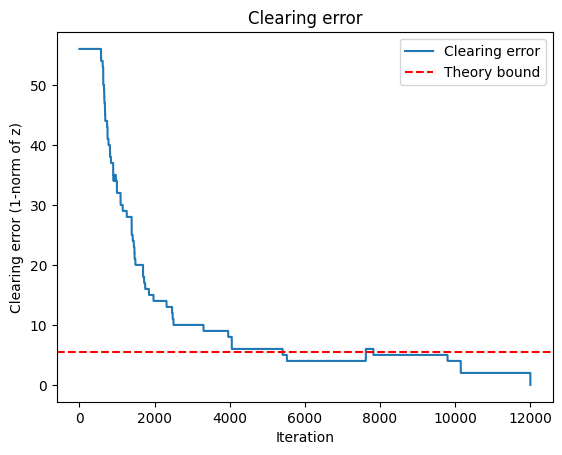

In [ ]:
error = res[5]

## Arrange the plot

#empirical
x_axis = np.array(range(0, len(error)))
plt.plot(x_axis, error, label="Clearing error")
plt.ylabel("Clearing error (1-norm of z)")
plt.xlabel("Iteration")

#theory bound
alpha = np.sqrt(min(2*100, len(cap))* len(cap))/2
plt.axhline(alpha, color="r", label="Theory bound", linestyle="dashed")


plt.title(f"Clearing error")
plt.legend(loc="upper right")

plt.show()

In [ ]:
errors=[]
with open("out2023-12-20 21:38:53.394530.txt", "r") as f:
  for lineno, line in enumerate(f):
    if line[0]=="z":
      err=np.array(line.split(" ")[1:]).astype("float").sum()
      errors.append(err)


[56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 56.0,
 55.0,
 54.0,
 52.0,
 52.0,
 52.0,
 52.0,
 52.0,
 52.0,
 51.0,
 50.0,
 50.0,
 48.0,
 48.0,
 48.0,
 47.0,
 45.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 43.0,
 40.0,
 40.0,
 40.0,
 38.0,
 36.0,
 35.0,
 35.0,
 35.0,
 35.0,
 34.0,
 33.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 29.0,
 29.0,
 28.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 25.0,
 25.0,
 25.0,
 24.0,

In [ ]:
with open('error.csv','w', newline='') as csvfile:
  writer = csv.writer(csvfile, delimiter=' ')
  for i in error:
    writer.writerow([i])
